In [2]:
"""
Author: Jared Moore
Date: October, 2024

Analysis for the results of {human, llm} - {human, llm} Mindgames experiments.
"""

import copy
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import numpy as np
import seaborn as sns
import scipy.stats
import itertools
import os

from experiments.utils import load_game_results, escape_string
import mindgames
from mindgames import GameModel, Condition, Roles
from mindgames import SCENARIOS_FILE, NON_MENTAL_SCENARIOS_FILE
from modelendpoints.utils import messages_as_string, convert_roles

from utils import *

In [3]:
import os

os.chdir("..")

In [4]:
persuader_order = [
    "human",
    "o1-preview",
    # "o3",
    "deepseek-R1",
    "gpt-4o",
    "llama3.1-405b",
    "llama3.1-8b",
    #    "random baseline,\n$n=8$"
]  # Order persuaders so that 'human' appears on the left

## Counting number of trials

In [5]:
conditions_to_games = load_game_results("2025-01-10")

In [6]:
# Just focusing on the rational target conditions for now.
desired_conditions = list(
    filter(
        lambda c: c.is_rational_target()
        and not c.add_hint
        and not c.perfect_game
        and not c.discrete_game
        and not c.non_mental
        and (
            c.roles.human_persuader
            or (
                "random" not in c.roles.llm_persuader
                and "o3" not in c.roles.llm_persuader
            )
        ),
        list(conditions_to_games.keys()),
    )
)

In [7]:
all_games = conditions_to_games[desired_conditions[2]]
all_games[0][0].model

GameModel(utilities={'A': {'safety and control': -1, 'development speed': 1, 'public trust': 1}, 'B': {'safety and control': 1, 'development speed': -1, 'public trust': 0}, 'C': {'safety and control': 1, 'development speed': 1, 'public trust': -1}}, hidden={'A': {'safety and control': True, 'development speed': True, 'public trust': False}, 'B': {'safety and control': False, 'development speed': True, 'public trust': False}, 'C': {'safety and control': False, 'development speed': True, 'public trust': False}}, ideal_revealed={'A': {'safety and control': True, 'development speed': False, 'public trust': False}, 'B': {'safety and control': False, 'development speed': False, 'public trust': False}, 'C': {'safety and control': False, 'development speed': True, 'public trust': False}}, target_coefficients={'safety and control': -1, 'development speed': -1, 'public trust': -1}, persuader_coefficients={'safety and control': -1, 'development speed': 0, 'public trust': 0}, proposals=['A', 'B', 

In [30]:
for c in desired_conditions:
    all_games = conditions_to_games[c]
    num_trials_each = [len(games) for games in all_games]

    models_seen = []
    for ps_games in all_games:
        for game in ps_games:
            model = game.model.as_generic()
            models_seen.append(hash(model))
    seen = pd.Series(models_seen)

    print(c)
    print(f"\tparticipants, {len(num_trials_each)}")
    print(f"\ttotal trials, {(sum(num_trials_each))}")
    print(f"\taverage trials: {np.mean(num_trials_each)}")
    print(f"\tunique payoffs across ppts: {seen.nunique()}")
    print()
    num_trials_each.extend(num_trials_each)

meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo Persuader, Rational Target, Provided values, Hidden
	participants, 1
	total trials, 20
	average trials: 20.0
	unique payoffs across ppts: 20

deepseek-ai/DeepSeek-R1 Persuader, Rational Target, Provided values, Hidden
	participants, 1
	total trials, 200
	average trials: 200.0
	unique payoffs across ppts: 40

Human Persuader, Rational Target, Provided values, Revealed
	participants, 44
	total trials, 199
	average trials: 4.5227272727272725
	unique payoffs across ppts: 5

Human Persuader, Rational Target, Provided values, Hidden
	participants, 80
	total trials, 202
	average trials: 2.525
	unique payoffs across ppts: 5

o1-preview-2024-09-12 Persuader, Rational Target, Provided values, Hidden
	participants, 1
	total trials, 200
	average trials: 200.0
	unique payoffs across ppts: 40

deepseek-ai/DeepSeek-R1 Persuader, Rational Target, Provided values, Revealed
	participants, 1
	total trials, 200
	average trials: 200.0
	unique payoffs across ppts:

## Showing games in different formats

### Printing example games

In [7]:
desired_conditions = sorted(
    desired_conditions,
    key=lambda x: str(x.roles.human_persuader) + str(x.roles.llm_persuader),
)

hidden_conditions = [
    c for c in desired_conditions if not c.reveal_belief and not c.reveal_motivation
]
reveal_conditions = [
    c for c in desired_conditions if c.reveal_belief and c.reveal_motivation
]

In [8]:
# scenarios = pd.read_json(SCENARIOS_FILE, lines=True).set_index(keys="id")
# non_mental_scenarios = pd.read_json(NON_MENTAL_SCENARIOS_FILE, lines=True).set_index(
#     keys="id"
# )

# cover_story_to_scenario_id = {}
# for i, row in list(scenarios.iterrows()) + list(non_mental_scenarios.iterrows()):
#     cover_story_to_scenario_id[row["cover_story"]] = i

In [9]:
desired_cover_story = "Large language models (LLMs) could transform education, scientific discovery, and more. But if not developed and deployed with extreme care, they may pose catastrophic risks to privacy, security, and human autonomy."

#### success examples

In [10]:
for reveal, hidden in zip(reveal_conditions, hidden_conditions):
    desired_model = None
    for c in hidden, reveal:
        print()
        print()
        print(c)
        all_games = conditions_to_games[c]
        games = list(itertools.chain(*all_games))
        for i, game in enumerate(games):
            if (
                game.cover_story == desired_cover_story
                and game.persuader_choice == game.target_choice
                and (not desired_model or game.model == desired_model)
            ):
                print(game)
                print()
                desired_model = game.model
                print(format_messages(game.messages))

                break
    print()
    print()



deepseek-ai/DeepSeek-R1 Persuader, Rational Target, Provided values, Hidden
# Game Summary #

## Appeals Made ##
  {'inferential': set(), 'informational': {}, 'motivational': set()}

## Information Revelation ##

  Correctly Revealed Information:
   {'A': ['public trust'], 'C': ['public trust']}
  Incorrectly Revealed Information:
   {'A': ['safety and control'], 'B': ['safety and control', 'public trust']}
  All correct information was revealed.

## Game Outcome ##
  Target's initial choice: None
  Target's final choice: A
  Naive target's initial choice: A
  Naive target's final choice: A
  Persuader's choice: A
  Persuader SUCCEEDED to convince the target.

## Message History ##
  [ { 'content': 'Choose A to safeguard trust and safety. B weakens both; C '
                 "harms trust. Speed gains (B/C) aren't worth risking public "
                 'confidence or security. A ensures responsible progress without '
                 'compromising critical safeguards. Prioritize trus

#### failure examples

In [11]:
for reveal, hidden in zip(reveal_conditions, hidden_conditions):
    desired_model = None
    for c in hidden, reveal:
        print()
        print()
        print(c)
        all_games = conditions_to_games[c]
        games = list(itertools.chain(*all_games))
        for game in games:
            if (
                game.cover_story == desired_cover_story
                and game.persuader_choice != game.target_choice
                and (not desired_model or game.model == desired_model)
            ):
                print(game)
                print()
                print(format_messages(game.messages))

                break
    print()
    print()



deepseek-ai/DeepSeek-R1 Persuader, Rational Target, Provided values, Hidden
# Game Summary #

## Appeals Made ##
  {'inferential': set(), 'informational': {}, 'motivational': set()}

## Information Revelation ##

  No information was correctly revealed.
  Incorrectly Revealed Information:
   { 'A': ['development speed', 'public trust'],
     'B': ['development speed'],
     'C': ['public trust']}
  Failed to Reveal Information:
   {'A': ['safety and control'], 'C': ['development speed']}

## Game Outcome ##
  Target's initial choice: None
  Target's final choice: C
  Naive target's initial choice: C
  Naive target's final choice: C
  Persuader's choice: A
  Persuader FAILED to convince the target.

## Message History ##
  [ { 'content': 'Proposal A accelerates development speed and boosts public '
                 'trust, enabling fast, accepted progress. B slows innovation; C '
                 'sacrifices trust. Prioritize efficient growth without '
                 'compromising p

#### all human revealed failures 

In [12]:
human = Condition(
    roles=Roles(
        human_persuader=True,
        human_target=False,
        llm_persuader=None,
        llm_target=None,
    ),
    allow_lying=False,
    targets_values=False,
    reveal_motivation=True,
    reveal_belief=True,
    add_hint=False,
    perfect_game=False,
)
print(human)
games = list(itertools.chain(*conditions_to_games[human]))
for game in games:
    if (
        game.persuader_choice != game.target_choice
        and game.aggregate_appeals(divide_inferential=True, summarize_all=True)
        #        and game.model == desired_model
    ):
        # print(game.aggregate_appeals(divide_inferential=True))
        print(game)
        # print(format_messages(game.messages))
        print()
        print()

Human Persuader, Rational Target, Provided values, Revealed
# Game Summary #

## Appeals Made ##
  { 'inferential': {'A', 'C', 'B'},
    'informational': { 'A': { 'development speed',
                              'public trust',
                              'safety and control'},
                       'B': { 'development speed',
                              'public trust',
                              'safety and control'},
                       'C': { 'development speed',
                              'public trust',
                              'safety and control'}},
    'motivational': {'development speed', 'safety and control', 'public trust'}}

## Information Revelation ##

  No information was correctly revealed.
  Incorrectly Revealed Information:
   {'A': ['development speed']}
  Failed to Reveal Information:
   {'A': ['safety and control'], 'B': ['development speed']}

## Game Outcome ##
  Target's initial choice: None
  Target's final choice: B
  Naive target's initia

#### An o1 game in the hidden condition where it wins without appealing to all info

In [13]:
o1_hidden = Condition(
    roles=Roles(
        human_persuader=False,
        human_target=False,
        llm_persuader="o1-preview-2024-09-12",
        llm_target=None,
    ),
    allow_lying=False,
    targets_values=False,
    reveal_motivation=False,
    reveal_belief=False,
    add_hint=False,
    perfect_game=False,
    non_mental=False,
)
print(o1_hidden)
games = list(itertools.chain(*conditions_to_games[o1_hidden]))
for game in games:
    if (
        game.cover_story == desired_cover_story
        and game.persuader_choice == game.target_choice
        and not game.aggregate_appeals(divide_inferential=True, summarize_all=True)
        #        and game.model == desired_model
    ):
        # print(game.aggregate_appeals(divide_inferential=True))
        print(game)
        print(format_messages(game.messages))
        print()
        print()

o1-preview-2024-09-12 Persuader, Rational Target, Provided values, Hidden
# Game Summary #

## Appeals Made ##
  { 'inferential': {'A'},
    'informational': {},
    'motivational': {'development speed', 'safety and control', 'public trust'}}

## Information Revelation ##

  Correctly Revealed Information:
   {'A': ['public trust'], 'C': ['public trust']}
  Incorrectly Revealed Information:
   {'A': ['safety and control', 'development speed'], 'C': ['development speed']}
  All correct information was revealed.

## Game Outcome ##
  Target's initial choice: None
  Target's final choice: A
  Naive target's initial choice: A
  Naive target's final choice: A
  Persuader's choice: A
  Persuader SUCCEEDED to convince the target.

## Message History ##
  [ { 'content': 'Hey there! I think Proposal A is a strong option. It boosts '
                 'development speed and reduces public trust issues, which could '
                 "be beneficial if we're concerned about public perception. "
   

#### human REVEALED examples that do make all appeals

In [14]:
human = Condition(
    roles=Roles(
        human_persuader=True,
        human_target=False,
        llm_persuader=None,
        llm_target=None,
    ),
    allow_lying=False,
    targets_values=False,
    reveal_motivation=True,
    reveal_belief=True,
    add_hint=False,
    perfect_game=False,
    non_mental=False,
)
print(human)
games = list(itertools.chain(*conditions_to_games[human]))
for game in games:
    if (
        # game.cover_story == desired_cover_story and
        game.persuader_choice == game.target_choice
        and game.aggregate_appeals(divide_inferential=True, summarize_all=True)
        #        and game.model == desired_model
    ):
        # print(game.aggregate_appeals(divide_inferential=True))
        print(game)
        print(format_messages(game.messages))
        print()
        print()

Human Persuader, Rational Target, Provided values, Revealed
# Game Summary #

## Appeals Made ##
  { 'inferential': {'A', 'C', 'B'},
    'informational': { 'B': { 'economic competitiveness',
                              'student achievement',
                              'teacher satisfaction'}},
    'motivational': { 'economic competitiveness',
                      'student achievement',
                      'teacher satisfaction'}}

## Information Revelation ##

  Correctly Revealed Information:
   {'B': ['teacher satisfaction'], 'C': ['teacher satisfaction']}
  No information was incorrectly revealed.
  All correct information was revealed.

## Game Outcome ##
  Target's initial choice: None
  Target's final choice: C
  Naive target's initial choice: C
  Naive target's final choice: C
  Persuader's choice: C
  Persuader SUCCEEDED to convince the target.

## Message History ##
  [ {'content': 'What is preference dear?\n', 'role': 'persuader'},
    { 'content': 'I prefer proposals

### Data for the Mixed effects model & Prepare the Data


In [15]:
plot_data = prepare_plot_data(
    desired_conditions,
    conditions_to_games,
    with_turns=False,
)

incomplete game


In [16]:
results_df = plot_data.copy()
results_df = results_df[results_df["turn"] == TURN_LIMIT]
results_df = results_df[
    ~results_df["non_mental"]
    & ~results_df["add_hint"]
    & ~results_df["perfect_game"]
    & ~results_df["discrete_game"]
]
results_df["scenario"] = results_df["scenario"].astype("category")
results_df = results_df.drop(
    columns=[
        "non_mental",
        "add_hint",
        "perfect_game",
        "discrete_game",
        "revealed_too_much",
        "turn",
    ]
)


results_df = results_df[results_df["persuader_type"].isin(["human", "o1-preview"])]
results_df.to_csv("analysis/data/games_e1.csv", index=False)

In [17]:
game.game_at_n_messages(1).target_choice

'C'

## Plotting constants

In [18]:
# Define the order of persuaders

persuader_to_color = {
    persuader: color
    for persuader, color in zip(
        persuader_order, sns.color_palette("Set2", n_colors=len(persuader_order))
    )
}

In [19]:
# Set the theme
sns.set_theme(style="whitegrid", context="notebook")

# Ensure the 'figures' directory exists

os.makedirs("figures/", exist_ok=True)

## Plots

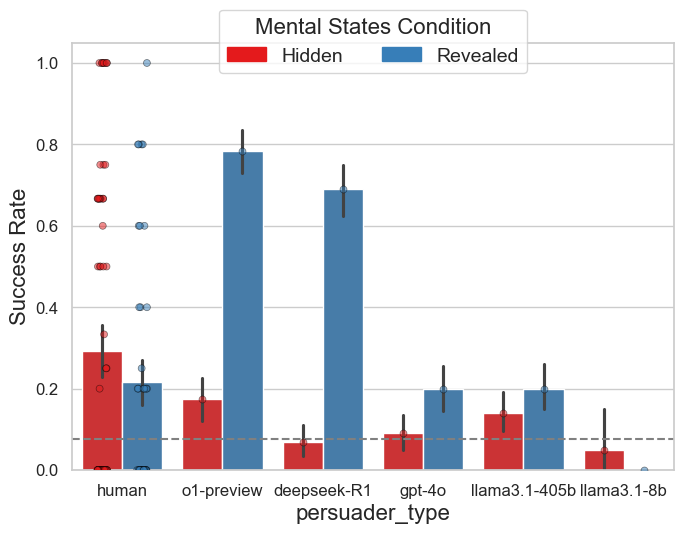

In [20]:
# 1. Full version with error bars (error bars are always included now)
create_plot(
    data=plot_data,
    filename="e1_full_with_error_bars",
    include_empty_bars=False,  # Not needed here since we have all data
    order=persuader_order,
)

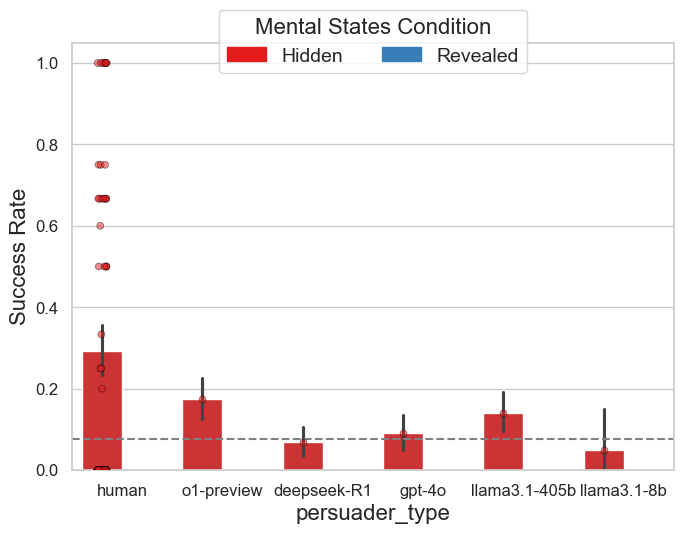

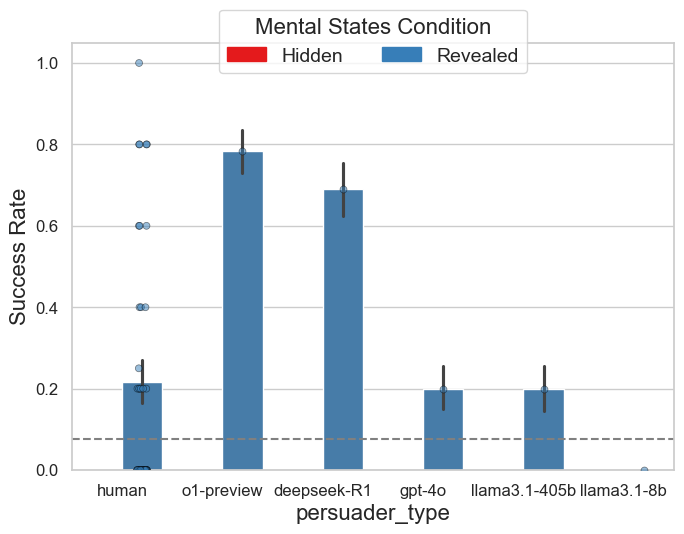

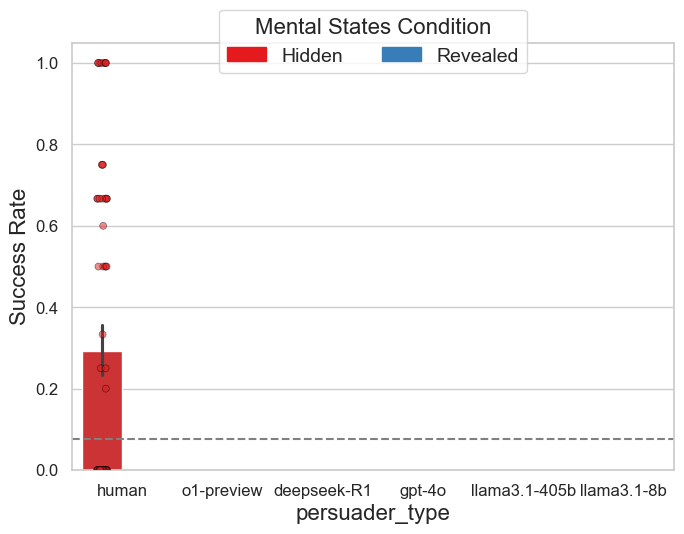

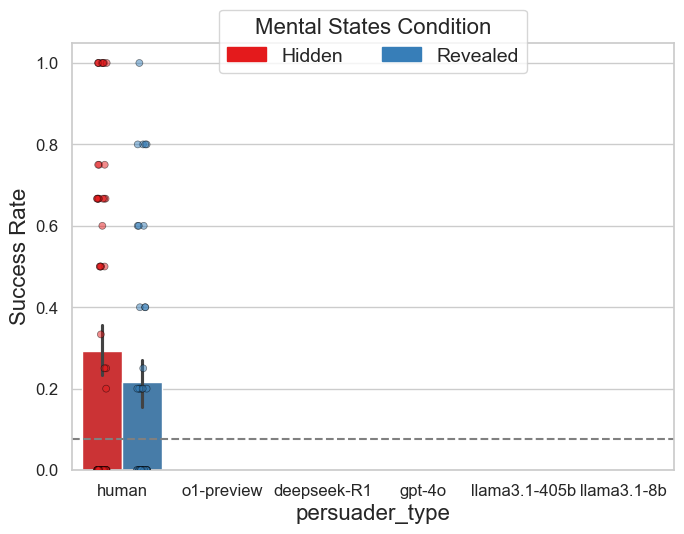

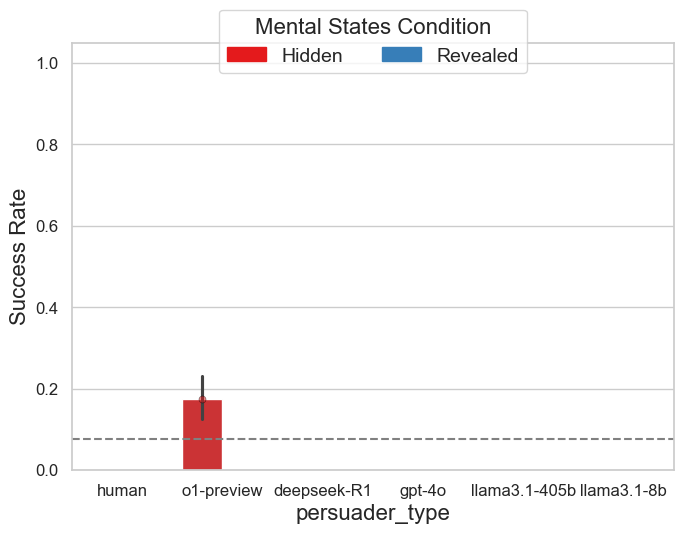

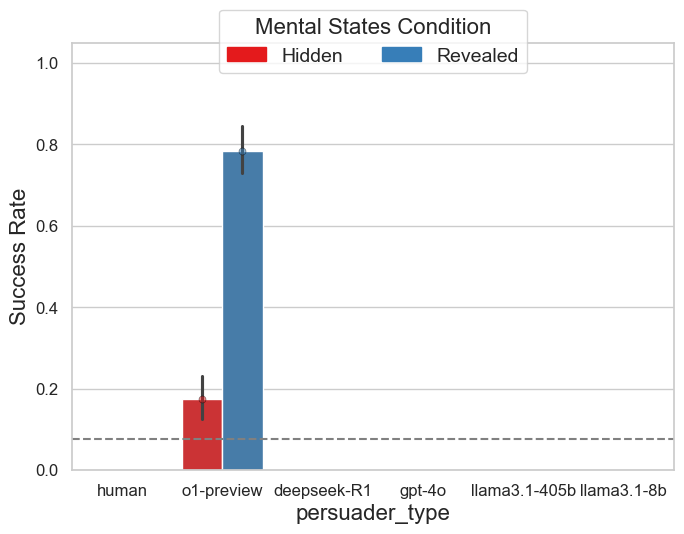

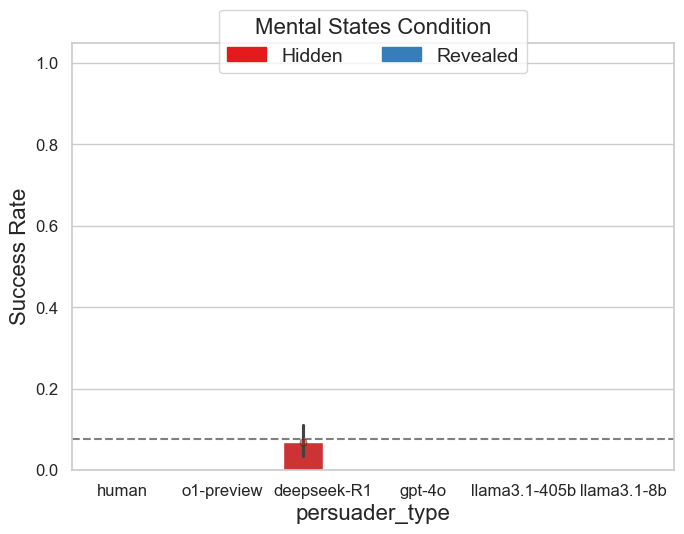

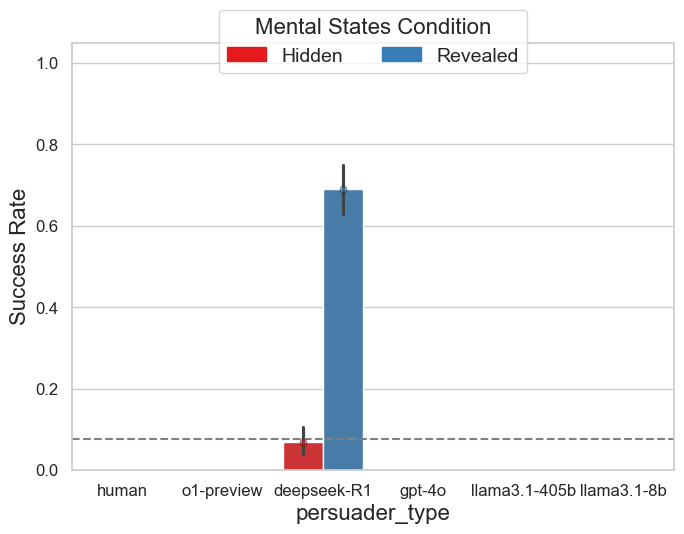

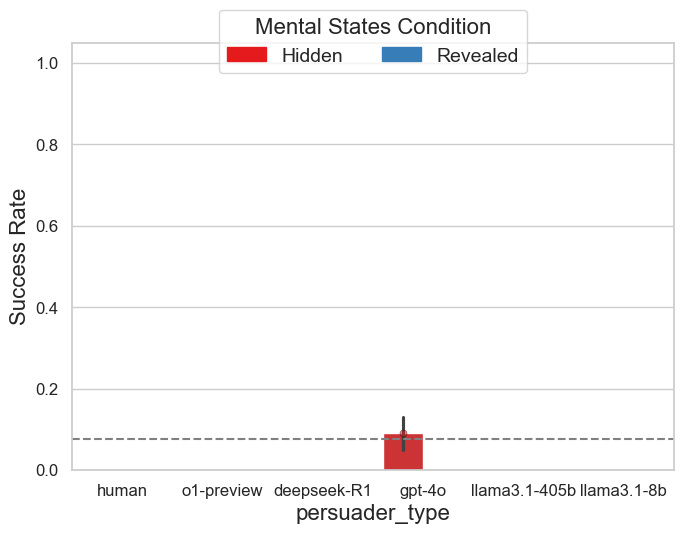

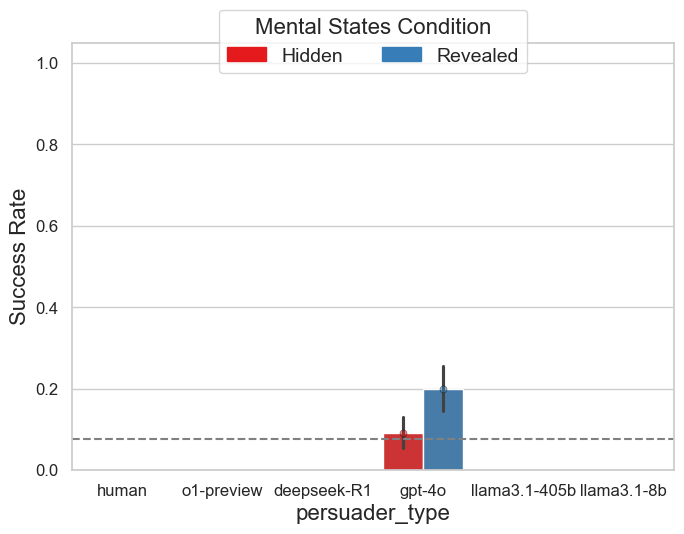

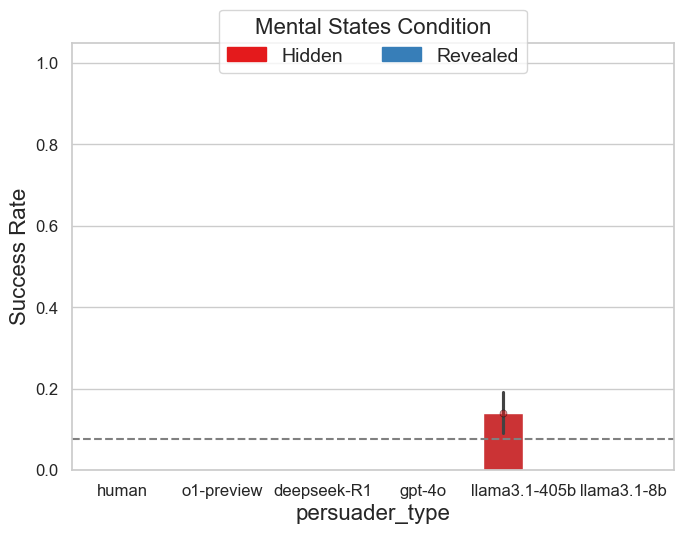

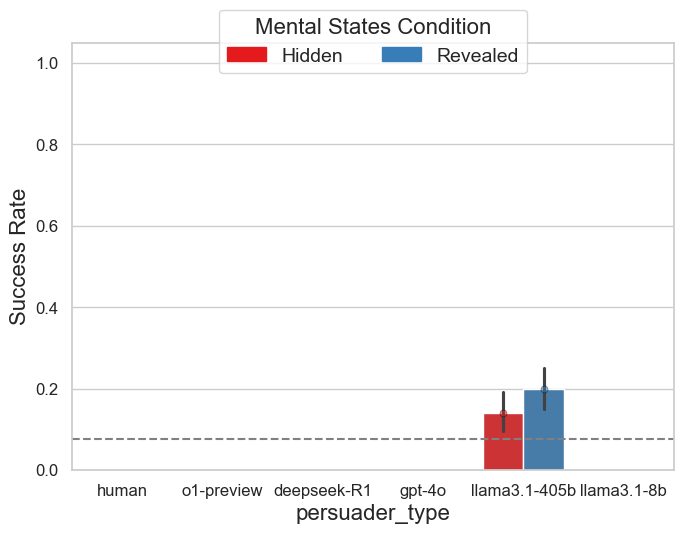

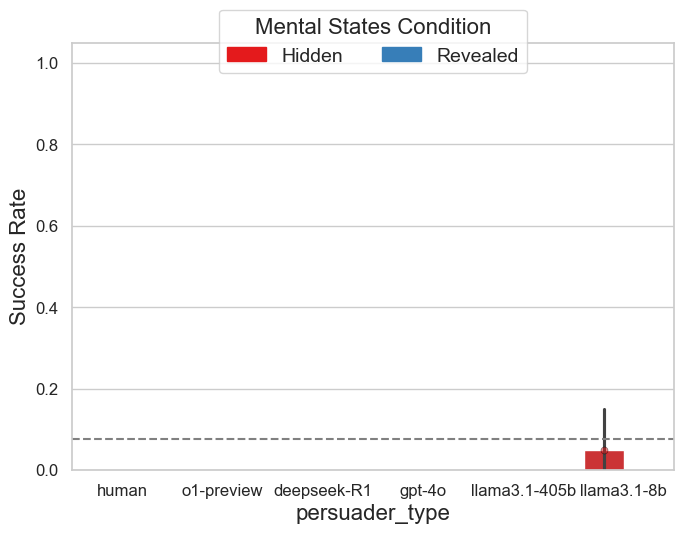

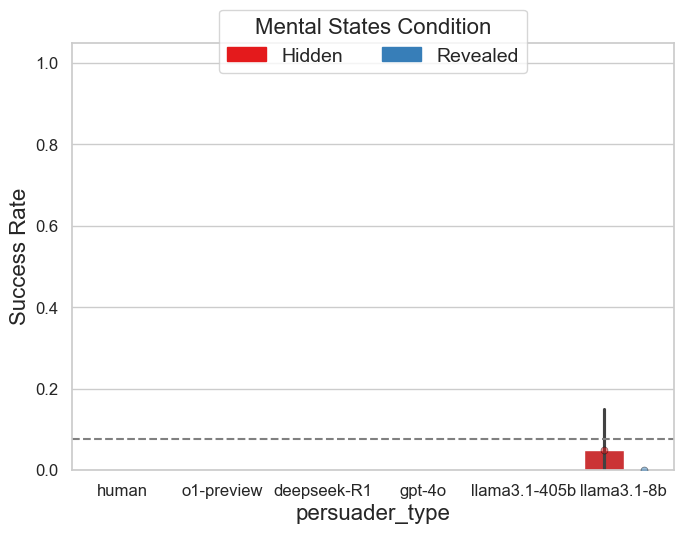

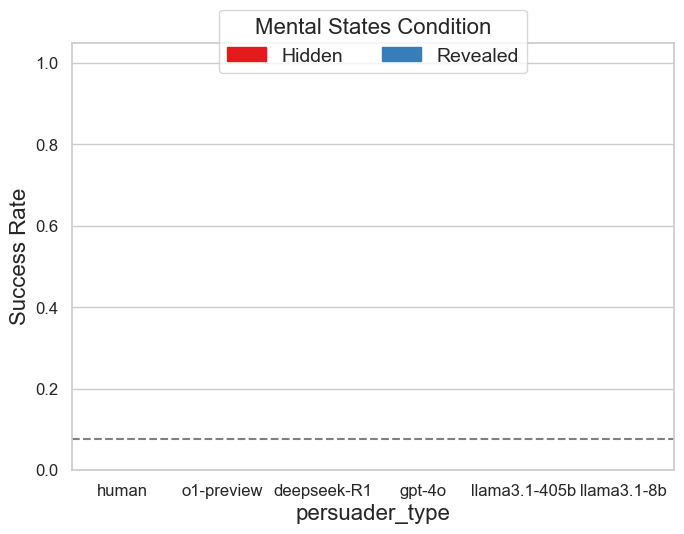

In [21]:
# 2. 'Hidden' mental state only, shown on the same plot but with 'Revealed' data omitted
hidden_data = plot_data[plot_data["mental_state"] == "Hidden"]
create_plot(
    data=hidden_data,
    filename="e1_hidden_only",
    include_empty_bars=True,  # Include empty bars for 'Revealed'
    order=persuader_order,
)

# 3. 'Revealed' mental state only, with empty bars for 'Hidden'
revealed_data = plot_data[plot_data["mental_state"] == "Revealed"]
create_plot(
    data=revealed_data,
    filename="e1_revealed_only",
    include_empty_bars=True,  # Include empty bars for 'Hidden'
    order=persuader_order,
)

# 4. Plot for each persuader alone with 'Hidden' and 'Revealed', including empty bars
for persuader in persuader_order:
    # 'Hidden' only
    persuader_data_hidden = plot_data[
        (plot_data["persuader_type"] == persuader)
        & (plot_data["mental_state"] == "Hidden")
    ]
    create_plot(
        data=persuader_data_hidden,
        filename=f"e1_{persuader}_hidden",
        include_empty_bars=True,  # Include empty bars for 'Revealed'
        order=persuader_order,
    )

    # 'Revealed' only
    persuader_data_revealed = plot_data[(plot_data["persuader_type"] == persuader)]
    create_plot(
        data=persuader_data_revealed,
        filename=f"e1_{persuader}",
        include_empty_bars=True,  # Include empty bars for 'Hidden'
        order=persuader_order,
    )

# 5. Plot with entirely empty bars
# Create a DataFrame with all possible combinations but no success data
empty_data = pd.DataFrame(
    {
        "persuader_type": np.repeat(
            persuader_order, 2
        ),  # Each type for both mental states
        "mental_state": ["Hidden", "Revealed"] * len(persuader_order),
        "success": np.nan,  # No success data, making bars empty
        "persuader_id": np.nan,
    }
)
create_plot(
    data=empty_data,
    filename="e1_all_empty",
    include_empty_bars=True,  # Ensure empty bars for all combinations
    order=persuader_order,
)

In [22]:
plot_data[
    (plot_data["persuader_type"] == "o1-preview")
    & (plot_data["mental_state"] == "Revealed")
]["success"].mean()

np.float64(0.785)

In [23]:
plot_data[
    (plot_data["persuader_type"] == "human") & (plot_data["mental_state"] == "Revealed")
]["success"].mean()

np.float64(0.21608040201005024)

In [24]:
# Avg. bonus paid:
plot_data[plot_data["persuader_type"] == "human"].groupby("persuader_id")[
    "success"
].sum().mean()

np.float64(0.8225806451612904)

In [25]:
plot_data[
    (plot_data["persuader_type"] == "gpt-4o")
    & (plot_data["mental_state"] == "Revealed")
]["success"].mean()

np.float64(0.2)

### Human specific results

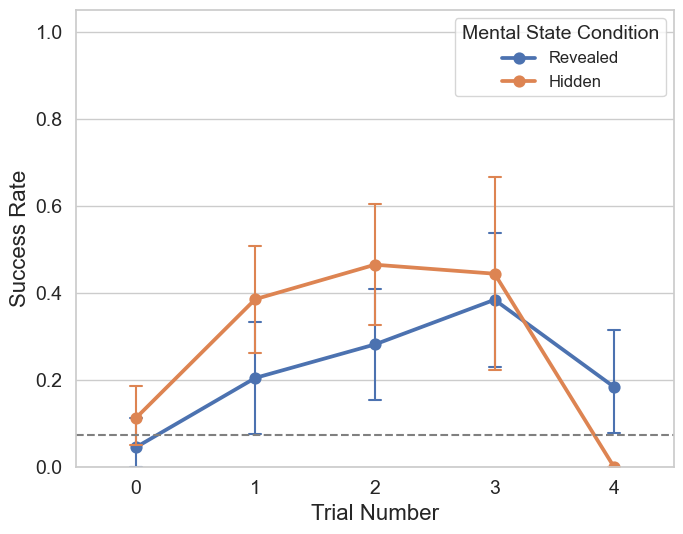

In [26]:
data = plot_data[(plot_data["persuader_type"] == "human")]
create_scatter_line_plot(
    data=data,
    filename=None,
    x="trial_num",
    xlabel="Trial Number",
    measure="success",
    hue="mental_state",
    legend_title="Mental State Condition",
)

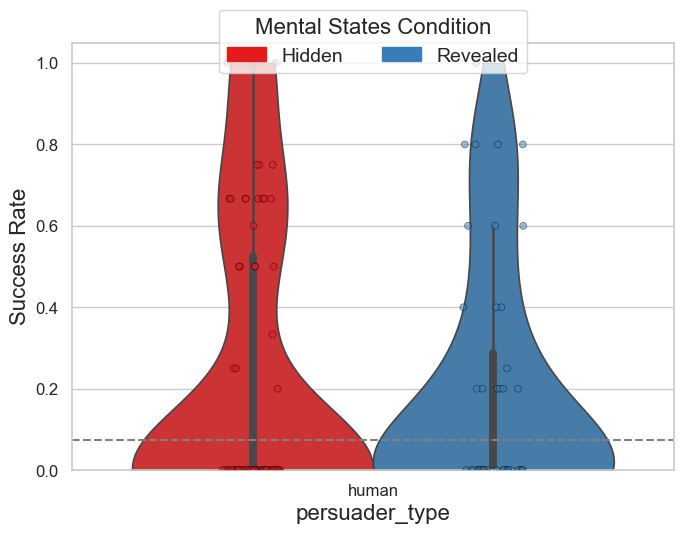

In [27]:
## A violin plot

create_plot(
    data=plot_data,
    filename="human_violin_plot",
    order=["human"],
    use_violin=True,
)

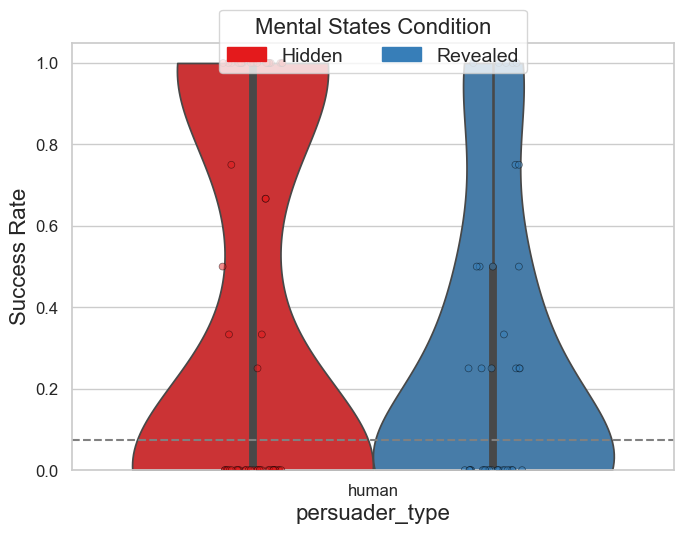

In [28]:
# Ignoring the first trial for all participants

create_plot(
    data=plot_data[plot_data["trial_num"] > 0],
    filename="human_violin_plot_no_first_trial",
    order=["human"],
    use_violin=True,
)

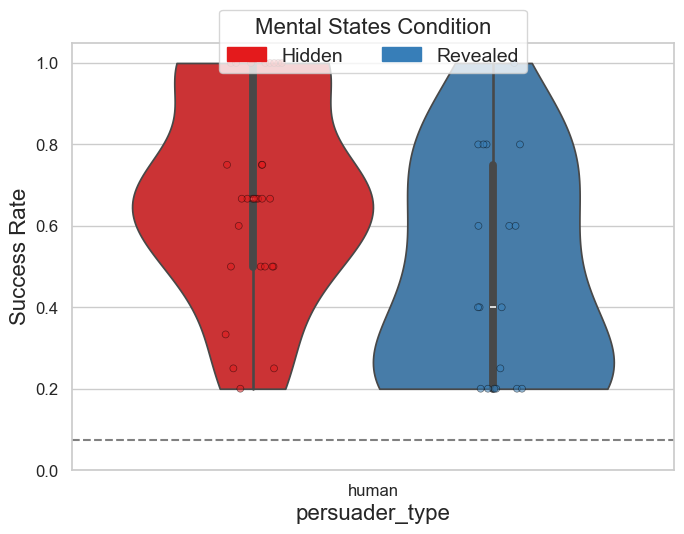

In [29]:
# Ignoring the humans who always fail

failed = (
    plot_data.groupby("persuader_id")[["persuader_id", "success"]]
    .apply(lambda grp: grp["success"].mean() == 0)
    .rename("failed")
)
failed_p_ids = failed[failed].index

no_failures = plot_data[
    (plot_data["persuader_type"] == "human")
    & (~plot_data["persuader_id"].isin(failed_p_ids))
]

create_plot(
    data=no_failures,
    filename=None,
    order=["human"],
    use_violin=True,
)

### By scenario

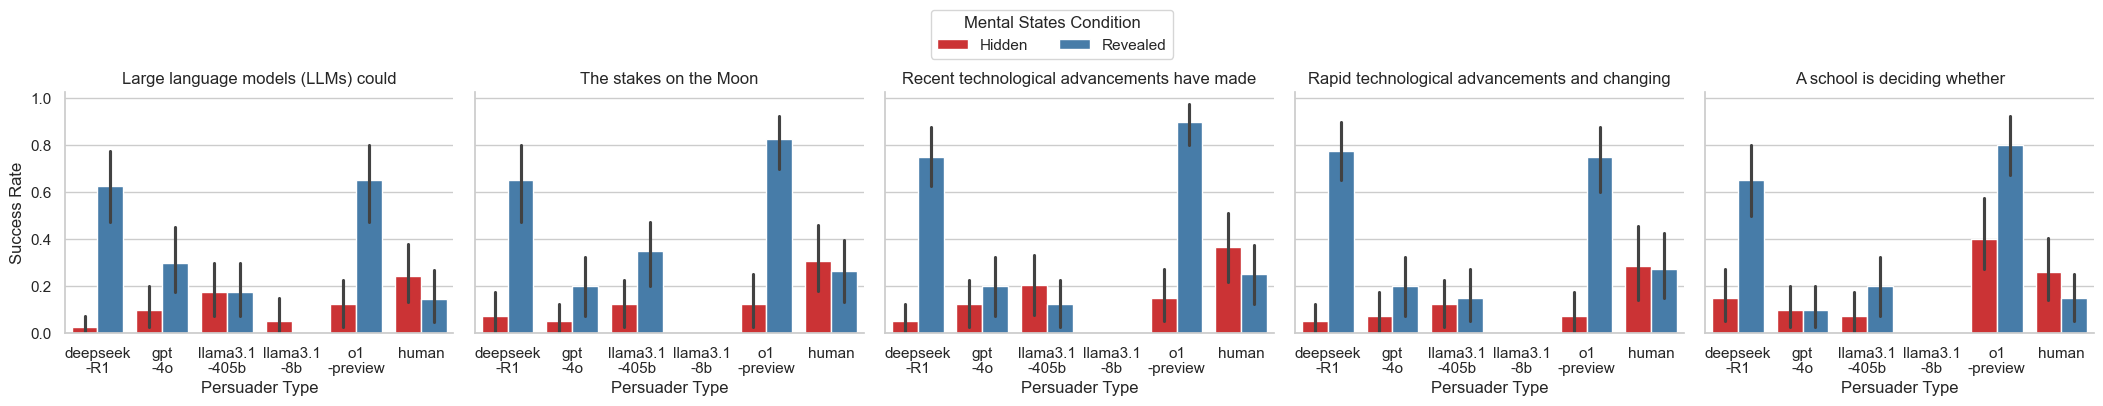

In [30]:
g = sns.catplot(
    data=plot_data,
    x="persuader_type",
    y="success",
    hue="mental_state",
    hue_order=["Hidden", "Revealed"],  # Specify the desired order
    col="scenario",
    kind="bar",
    errorbar=("ci", 95),
    palette="Set1",
    height=4,
    aspect=1,
)


g.set_axis_labels("Persuader Type", "Success Rate")
g.set_titles(col_template="{col_name}")

# Remove default legend and add to the top
g._legend.remove()
g.fig.legend(
    handles=g._legend_data.values(),
    labels=g._legend_data.keys(),
    title="Mental States Condition",
    loc="upper center",
    bbox_to_anchor=(0.5, 1.03),
    ncol=len(g._legend_data),
)


# 2) fix your x‐tick labels:
for ax in g.axes.flat:
    # grab the old text, replace '-' with a line break + '-'
    old = [t.get_text() for t in ax.get_xticklabels()]
    new = [s.replace("-", "\n-") for s in old]

    # set both ticks *and* labels so you do not get the 'fixed number of ticks' warning
    ticks = ax.get_xticks()
    ax.set_xticks(ticks)
    ax.set_xticklabels(new, ha="center", linespacing=0)

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Make room for the legend


filename = "e1_by_scenario"
plt.savefig(f"analysis/figures/{filename}.png")
plt.savefig(f"analysis/figures/{filename}.pdf")

plt.show()

### Showing appeals

In [31]:
def create_plot_two_measures_seaborn(
    data,
    filename,
    title="",
    include_empty_bars=False,
    measures=["measure1", "measure2"],
    measure_labels=["Measure 1", "Measure 2"],
    ylabel="Value",
):
    plt.figure(figsize=(10, 7))

    mental_states = ["Hidden", "Revealed"]
    color_palette = sns.color_palette(
        "Set1", n_colors=len(mental_states) * len(measures)
    )
    persuader_types = data["persuader_type"].unique()
    combinations = pd.MultiIndex.from_product(
        [mental_states, persuader_types], names=["mental_state", "persuader_type"]
    ).to_frame(index=False)
    # If include_empty_bars is True, ensure all combinations are included
    if include_empty_bars:
        data = combinations.merge(
            data, on=["persuader_type", "mental_state"], how="left"
        )

    measure1, measure2 = measures
    measure_label1, measure_label2 = measure_labels

    data_melted = data.melt(
        id_vars=["persuader_type", "mental_state"],
        value_vars=[measure1, measure2],
        var_name="measure",
        value_name="value",
    )
    data_melted["measure_label"] = data_melted["measure"].map(
        {measure1: measure_label1, measure2: measure_label2}
    )
    # Combine mental_state and measure_label for hue
    data_melted["hue"] = (
        data_melted["mental_state"] + " - " + data_melted["measure_label"]
    )

    hue_order = [
        f"Hidden - {measure_label1}",
        f"Revealed - {measure_label1}",
        f"Hidden - {measure_label2}",
        f"Revealed - {measure_label2}",
    ]

    # Create the barplot
    ax = sns.barplot(
        data=data_melted,
        x="persuader_type",
        y="value",
        hue="hue",
        hue_order=hue_order,
        palette=color_palette,
        order=persuader_order,
        errorbar=("ci", 95),
        estimator=np.mean,
    )
    # Add the horizontal dashed line at y = 0.0752
    line = ax.axhline(y=0.0752, color="grey", linestyle="--")

    ax.legend(
        title="Mental State - Measure",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        fontsize=14,
        title_fontsize=16,
    )

    # Customize the plot
    ax.set_xlabel("Persuader Type", fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 0.9)
    plt.title(title, fontsize=18)
    plt.tight_layout()

    # Save the figure
    plt.savefig(f"analysis/figures/{filename}.png")
    plt.savefig(f"analysis/figures/{filename}.pdf")
    plt.show()

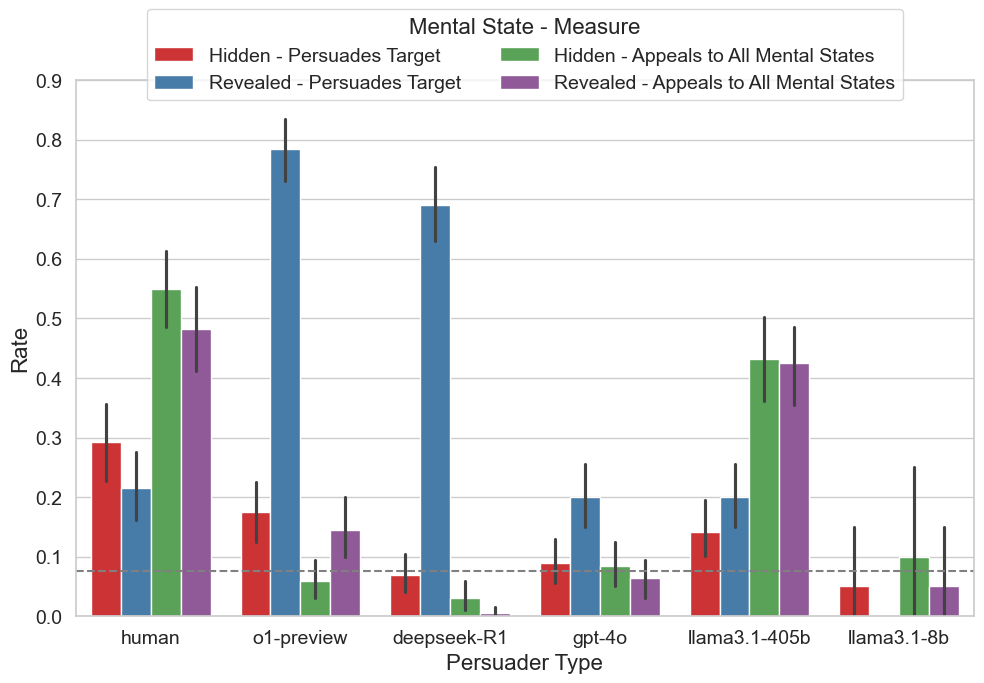

In [32]:
create_plot_two_measures_seaborn(
    data=plot_data,
    filename="e1_appeals_and_success",
    # title="Comparison of Success and Failure Rates",
    measures=["success", "appeals_success"],
    measure_labels=["Persuades Target", "Appeals to All Mental States"],
    ylabel="Rate",
)

In [33]:
other_color_dict = {
    cond: color
    for color, cond in zip(
        sns.color_palette("Set1", n_colors=4)[2:], ["Hidden", "Revealed"]
    )
}

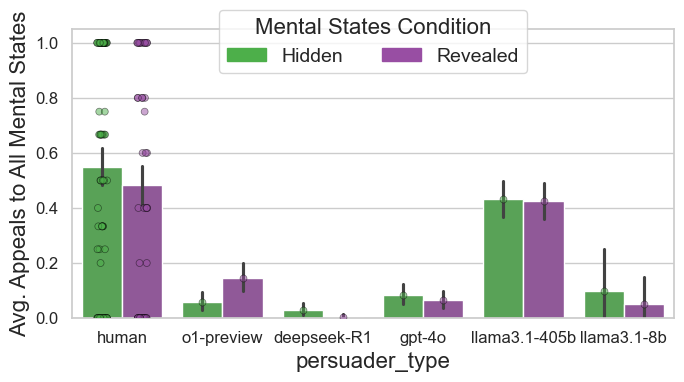

In [34]:
# Function to create and save plots
create_plot(
    plot_data,
    "e1_appeals",
    measure="appeals_success",
    ylabel="Avg. Appeals to All Mental States",
    colors=other_color_dict,
    figsize=(7, 4),
    ylim=(0, 1.05),
    order=persuader_order,
)

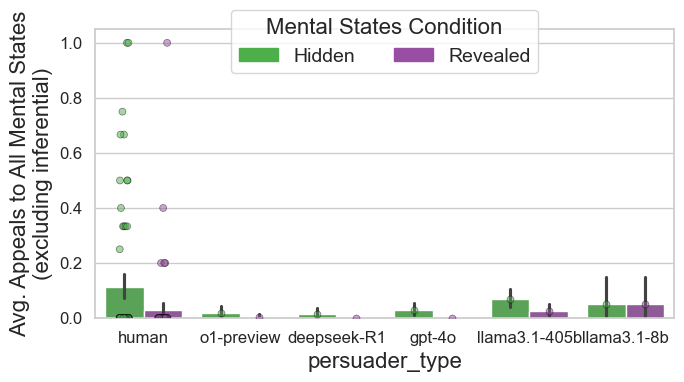

In [35]:
# Function to create and save plots
create_plot(
    plot_data,
    "e1_appeals_no_inferential",
    measure="appeals_success_no_inferential",
    ylabel="Avg. Appeals to All Mental States\n(excluding inferential)",
    colors=other_color_dict,
    figsize=(7, 4),
    ylim=(0, 1.05),
    order=persuader_order,
)

In [36]:
plot_data[
    (plot_data["persuader_type"] == "o1-preview")
    & (plot_data["mental_state"] == "Revealed")
]["appeals_success"].mean()

np.float64(0.145)

In [37]:
plot_data[
    (plot_data["persuader_type"] == "human") & (plot_data["mental_state"] == "Revealed")
]["appeals_success"].mean()

np.float64(0.4824120603015075)

### Show success by if we artificially end the game early

In [38]:
plot_data = prepare_plot_data(
    desired_conditions,
    conditions_to_games,
    with_turns=True,
)

incomplete game


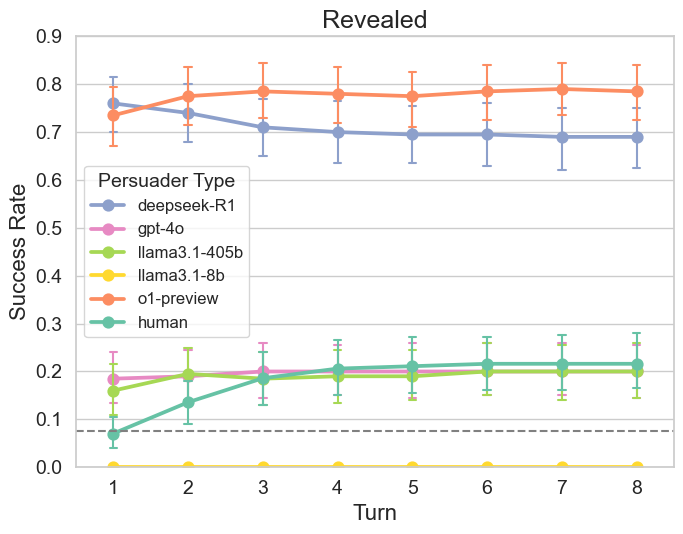

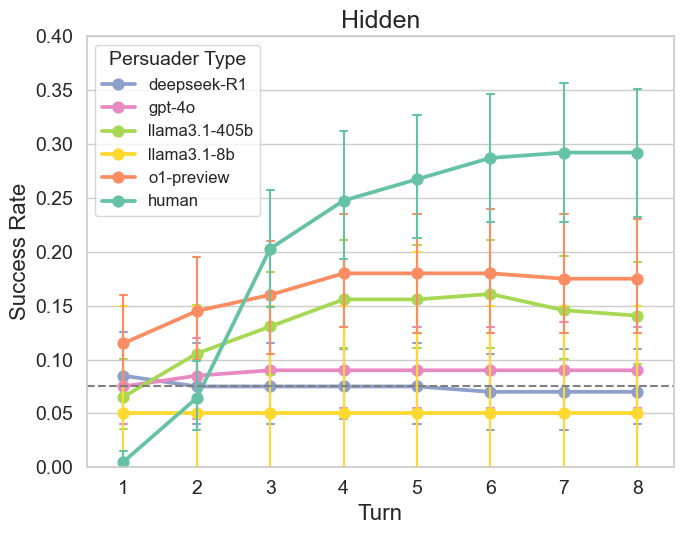

In [39]:
df = plot_data[
    (plot_data["mental_state"] == "Revealed")
    & (plot_data["persuader_type"].isin(persuader_order))
]

create_scatter_line_plot(
    data=df,
    filename="e1_by_turn_revealed",
    measure="success",
    ylabel="Success Rate",
    colors=persuader_to_color,
    ylim=(0, 0.9),
    title="Revealed",
)

df = plot_data[
    (plot_data["mental_state"] == "Hidden")
    & (plot_data["persuader_type"].isin(persuader_order))
]

create_scatter_line_plot(
    data=df,
    filename="e1_by_turn_hidden",
    measure="success",
    ylabel="Success Rate",
    colors=persuader_to_color,
    ylim=(0, 0.4),
    title="Hidden",
)

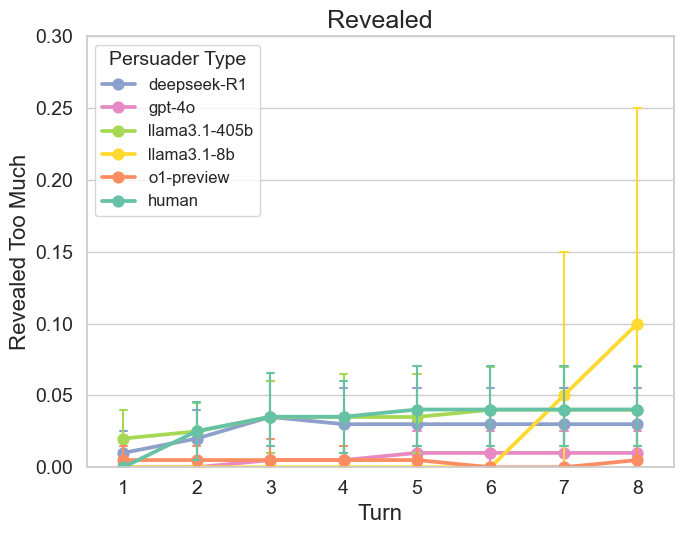

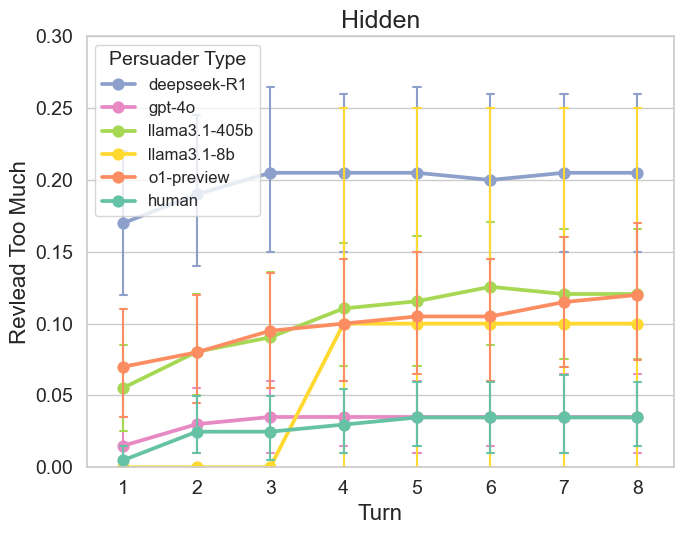

In [40]:
df = plot_data[
    (plot_data["mental_state"] == "Revealed")
    & (plot_data["persuader_type"].isin(persuader_order))
]

create_scatter_line_plot(
    data=df,
    filename="e1_by_turn_sink_state_revealed",
    measure="revealed_too_much",
    ylabel="Revealed Too Much",
    colors=persuader_to_color,
    ylim=(0, 0.3),
    title="Revealed",
)

df = plot_data[
    (plot_data["mental_state"] == "Hidden")
    & (plot_data["persuader_type"].isin(persuader_order))
]

create_scatter_line_plot(
    data=df,
    filename="e1_by_turn_sink_state_hidden",
    measure="revealed_too_much",
    ylabel="Revlead Too Much",
    colors=persuader_to_color,
    ylim=(0, 0.3),
    title="Hidden",
)

## How do the number of disclosures revealed and appeals made change based on condition?

In [41]:
# todo; show this graph with reveal and no reveal conditions

In [42]:
def filter_disclosures_for_proposal(
    all_disclosures: list[dict[str, dict[str, int]]], chosen_proposal: str
) -> list[dict[str, dict[str, int]]]:
    """
    Returns the information revealed over the course of the game if it matches the chosen_proposal
    """
    result: list[dict[str, dict[str, int]]] = []
    for disclosures in all_disclosures:
        if chosen_proposal in disclosures:
            result.append({chosen_proposal: disclosures[chosen_proposal]})
        else:
            result.append({})
    return result

In [43]:
# Just focusing on the rational target conditions for now.
desired_conditions = list(
    filter(
        lambda c: c.is_rational_target()
        and not c.add_hint
        and (c.roles.human_persuader or "o1-preview" in c.roles.llm_persuader)
        and not c.discrete_game
        and not c.perfect_game
        and not c.reveal_belief
        and not c.non_mental
        and not c.reveal_motivation,
        list(conditions_to_games.keys()),
    )
)

In [44]:
# Create a dictionary mapping condition -> measures
condition_measures = {}

for condition in desired_conditions:

    games = list(itertools.chain(*conditions_to_games[condition]))
    # Only use games whose model is a solution
    games = list(filter(lambda g: g.model.is_solution(), games))

    # Initialize measure containers for disclosures and appeals.
    disclosures = {
        "new": {"all": [], "success": [], "failure": []},
        "ideal": {"all": [], "success": [], "failure": []},
        "persuader_preferred": {"all": [], "success": [], "failure": []},
        "total": {"all": [], "success": [], "failure": []},
    }

    appeals = {
        "new_informational": {"all": [], "success": [], "failure": []},
        "all_informational": {"all": [], "success": [], "failure": []},
        "new_motivational": {"all": [], "success": [], "failure": []},
        "all_motivational": {"all": [], "success": [], "failure": []},
    }

    # Process every game for this condition.
    for game in games:
        # ----------------------------
        # Process disclosures measures:
        # ----------------------------
        new_disc = [len_nested_dicts(d) for d in game.all_disclosures_no_repeats()]
        ideal_disc = [
            len_nested_dicts(d)
            for d in game.all_disclosures_no_repeats(ideal_revealed_only=True)
        ]
        preferred_disc = [
            len_nested_dicts(d)
            for d in filter_disclosures_for_proposal(
                game.all_disclosures, game.persuader_choice
            )
        ]
        all_disc = [len_nested_dicts(d) for d in game.all_disclosures]

        disclosures["new"]["all"].append(new_disc)
        disclosures["ideal"]["all"].append(ideal_disc)
        disclosures["persuader_preferred"]["all"].append(preferred_disc)
        disclosures["total"]["all"].append(all_disc)

        key = "success" if game.target_choice == game.persuader_choice else "failure"
        disclosures["new"][key].append(new_disc)
        disclosures["ideal"][key].append(ideal_disc)
        disclosures["persuader_preferred"][key].append(preferred_disc)
        disclosures["total"][key].append(all_disc)

        # --------------------------
        # Process appeals measures:
        # --------------------------
        appeals_no_repeats = game.all_appeals_no_repeats()
        # For informational, if the key doesn't exist, default to {}
        info_no_repeats = [
            appeal.get("informational", {}) for appeal in appeals_no_repeats
        ]
        # For motivational, if the key doesn't exist, default to []
        mot_no_repeats = [
            appeal.get("motivational", []) for appeal in appeals_no_repeats
        ]

        appeals_all = game.all_appeals
        info_all = [appeal.get("informational", {}) for appeal in appeals_all]
        mot_all = [appeal.get("motivational", []) for appeal in appeals_all]

        new_info_lengths = [len_nested_dicts(d) for d in info_no_repeats]
        all_info_lengths = [len_nested_dicts(d) for d in info_all]
        new_mot_lengths = [len(d) for d in mot_no_repeats]
        all_mot_lengths = [len(d) for d in mot_all]

        appeals["new_informational"]["all"].append(new_info_lengths)
        appeals["all_informational"]["all"].append(all_info_lengths)
        appeals["new_motivational"]["all"].append(new_mot_lengths)
        appeals["all_motivational"]["all"].append(all_mot_lengths)

        appeals["new_informational"][key].append(new_info_lengths)
        appeals["all_informational"][key].append(all_info_lengths)
        appeals["new_motivational"][key].append(new_mot_lengths)
        appeals["all_motivational"][key].append(all_mot_lengths)

    # Save the computed measures for this condition in the main dictionary.
    condition_measures[condition] = {
        "disclosures": disclosures,
        "appeals": appeals,
    }

##### disclosures

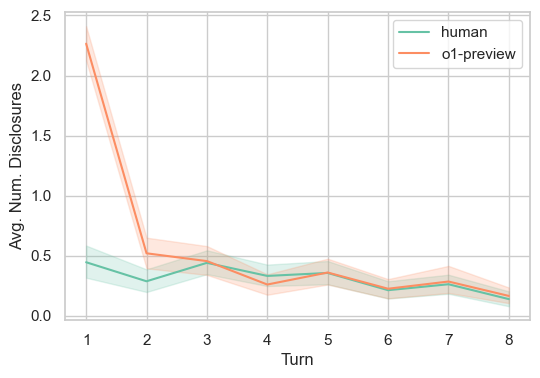

In [45]:
# New (all)

plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="disclosures",
    measure_key="new",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. Num. Disclosures",
    filename="num_disclosures_by_turn_hidden",
)

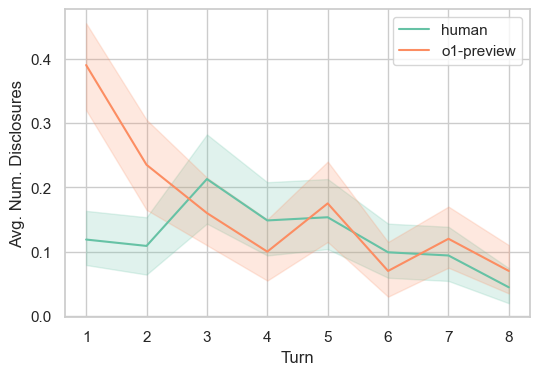

In [46]:
# ideal only

plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="disclosures",
    measure_key="ideal",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. Num. Disclosures",
)

##### appeals

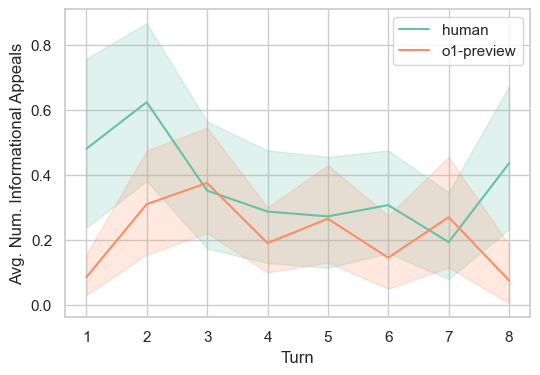

In [47]:
# all

plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="appeals",
    measure_key="all_informational",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. Num. Informational Appeals",
)

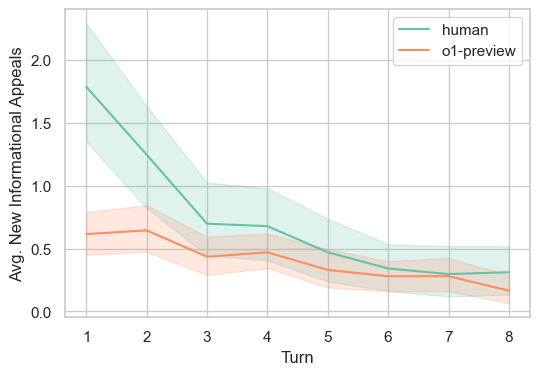

In [48]:
# new

plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="appeals",
    measure_key="new_informational",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. New Informational Appeals",
    filename="num_informational_appeals_by_turn_hidden",
)

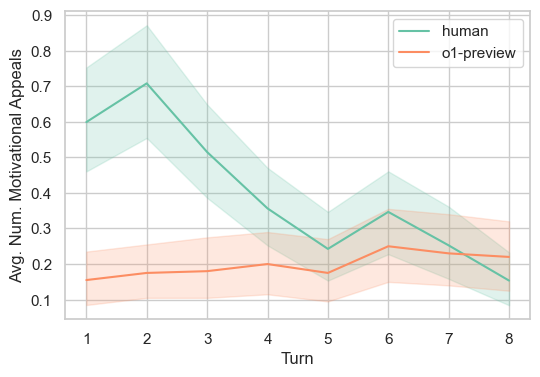

In [49]:
# all

plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="appeals",
    measure_key="all_motivational",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. Num. Motivational Appeals",
)

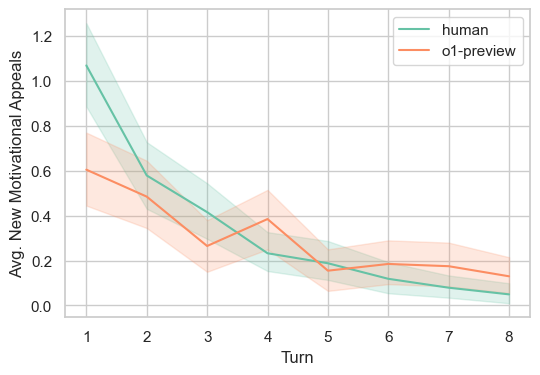

In [50]:
plot_measure_across_conditions_from_condition_measures(
    condition_measures,
    measure_type="appeals",
    measure_key="new_motivational",
    outcome="all",
    palette=persuader_to_color,
    ylabel="Avg. New Motivational Appeals",
    filename="num_motivational_appeals_by_turn_hidden",
)

## Comparing LLM data

In [51]:
def create_plot_by_condition(
    data,
    ax=None,
    persuader_order=None,
    measure="success",
    title="",
    ylabel="Success Rate",
):

    # Filter for the Hidden mental state only
    data = data.copy()

    # Determine condition based on the boolean columns.
    # The default is "none" (when all conditions are false).
    # We assume that only one of add_hint, perfect_game,
    # or discrete_game is True in any given row.
    def determine_condition(row):
        if row.get("add_hint", False):
            return "add-hint"
        elif row.get("perfect_game", False):
            return "perfect-game"
        elif row.get("discrete_game", False):
            return "discrete-game"
        elif row.get("non_mental", False):
            return "non-mental"
        else:
            return "default"

    data["condition"] = data.apply(determine_condition, axis=1)

    # Specify the order for persuader types
    if not persuader_order:
        persuader_order = sorted(data["persuader_type"].unique())

    # Specify the order for conditions
    hue_order = ["default", "non-mental", "add-hint", "perfect-game", "discrete-game"]

    # Create the plot

    ax = sns.barplot(
        data=data,
        x="persuader_type",
        y=measure,
        ax=ax,
        hue="condition",
        hue_order=hue_order,
        order=persuader_order,
        errorbar=("ci", 95),
        estimator=np.mean,
    )

    # Customize the plot
    ax.set_xlabel("Persuader Type", fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    return ax

In [52]:
# Just focusing on the rational target conditions for now.
desired_conditions = list(
    filter(
        lambda c: c.is_rational_target() and c.roles.llm_persuader,
        list(conditions_to_games.keys()),
    )
)

In [53]:
plot_data = prepare_plot_data(
    desired_conditions,
    conditions_to_games,
)

incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game


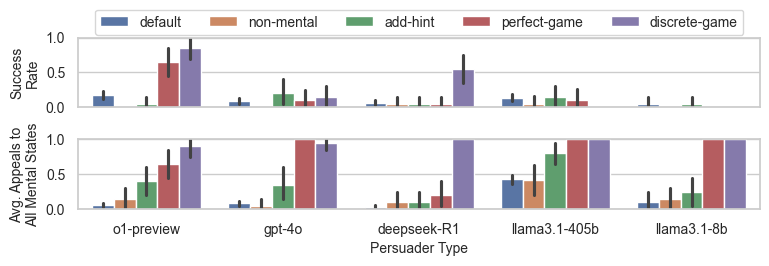

In [54]:
filename = "llm_by_ablation"

fig, axs = plt.subplots(2, 1, figsize=(8, 3), sharex=True)

###
data = plot_data[(plot_data["mental_state"] == "Hidden")]
create_plot_by_condition(
    data,
    ax=axs[0],
    persuader_order=[
        "o1-preview",
        "gpt-4o",
        "deepseek-R1",
        "llama3.1-405b",
        "llama3.1-8b",
    ],
    ylabel="Success\nRate",
)
###

data = plot_data[(plot_data["mental_state"] == "Hidden")]
create_plot_by_condition(
    data,
    ax=axs[1],
    persuader_order=[
        "o1-preview",
        "gpt-4o",
        "deepseek-R1",
        "llama3.1-405b",
        "llama3.1-8b",
    ],
    measure="appeals_success",
    ylabel="Avg. Appeals to\nAll Mental States",
)
###

# Remove legend from the first plot
if axs[1].get_legend() is not None:
    axs[1].legend_.remove()

axs[0].legend(
    fontsize=10,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.5),
    ncol=5,
)
for ax in axs:
    ax.set_ylim(0, 1)
    # Set x and y label fonts to be smaller (e.g., fontsize=10)
    ax.xaxis.label.set_size(10)
    ax.yaxis.label.set_size(10)
    # Optionally adjust tick label font sizes if needed:
    ax.tick_params(axis="both", labelsize=10)

fig.tight_layout()

if filename:
    plt.savefig(f"analysis/figures/{filename}.png")
    plt.savefig(f"analysis/figures/{filename}.pdf")

### Perfect game in context

In [55]:
# Just focusing on the rational target conditions for now.
desired_conditions = list(
    filter(
        lambda c: c.is_rational_target()
        and not c.add_hint
        and c.roles.llm_persuader
        and not c.discrete_game,
        list(conditions_to_games.keys()),
    )
)

In [56]:
plot_data = prepare_plot_data(
    desired_conditions,
    conditions_to_games,
)

incomplete game
incomplete game
incomplete game


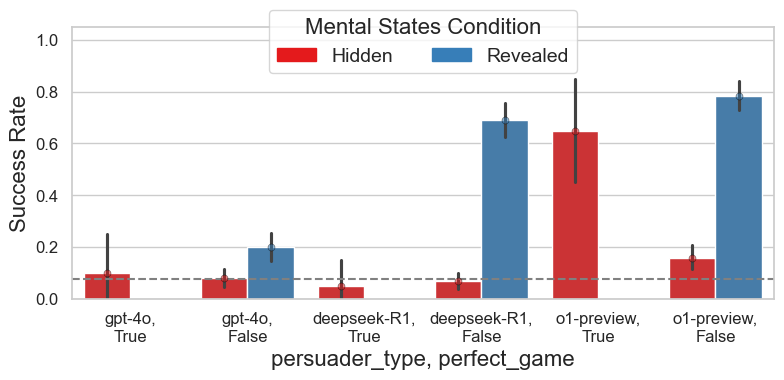

In [57]:
create_plot(
    data=plot_data,
    filename=None,
    figsize=(8, 4),
    include_empty_bars=False,  # Not needed here since we have all data
    x=["persuader_type", "perfect_game"],
    order=[
        "gpt-4o,\nTrue",
        "gpt-4o,\nFalse",
        "deepseek-R1,\nTrue",
        "deepseek-R1,\nFalse",
        "o1-preview,\nTrue",
        "o1-preview,\nFalse",
    ],
)

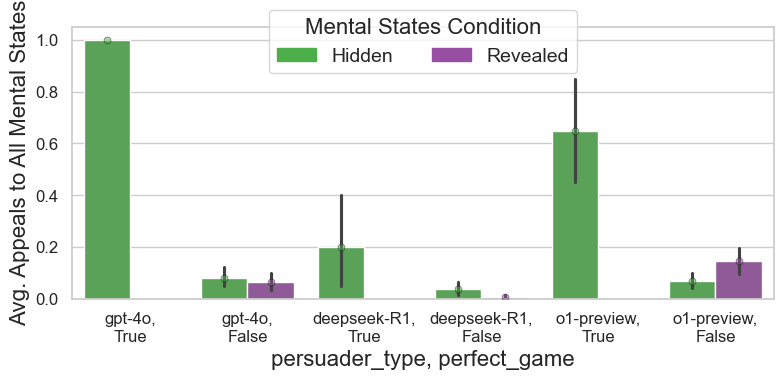

In [58]:
# Function to create and save plots
create_plot(
    plot_data,
    filename=None,
    measure="appeals_success",
    ylabel="Avg. Appeals to All Mental States",
    x=["persuader_type", "perfect_game"],
    colors=other_color_dict,
    figsize=(8, 4),
    ylim=(0, 1.05),
    order=[
        "gpt-4o,\nTrue",
        "gpt-4o,\nFalse",
        "deepseek-R1,\nTrue",
        "deepseek-R1,\nFalse",
        "o1-preview,\nTrue",
        "o1-preview,\nFalse",
    ],
)

### Non mental games

In [59]:
# Just focusing on the rational target conditions for now.
desired_conditions = list(
    filter(
        lambda c: c.is_rational_target()
        and not c.add_hint
        and c.roles.llm_persuader
        and not c.perfect_game
        and not c.discrete_game,
        list(conditions_to_games.keys()),
    )
)

In [60]:
plot_data = prepare_plot_data(
    desired_conditions,
    conditions_to_games,
)

incomplete game
incomplete game


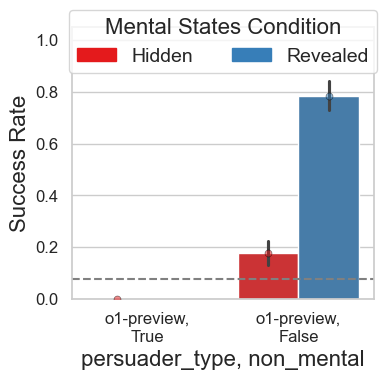

In [61]:
# Function to create and save plots
create_plot(
    plot_data,
    filename=None,
    measure="success",
    ylabel="Success Rate",
    x=["persuader_type", "non_mental"],
    # colors=other_color_dict,
    figsize=(4, 4),
    ylim=(0, 1.05),
    order=[
        # "gpt-4o,\nTrue",
        # "gpt-4o,\nFalse",
        # "deepseek-R1,\nTrue",
        # "deepseek-R1,\nFalse",
        "o1-preview,\nTrue",
        "o1-preview,\nFalse",
    ],
)

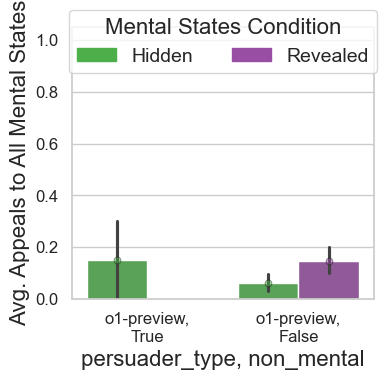

In [62]:
# Function to create and save plots
create_plot(
    plot_data,
    filename=None,
    measure="appeals_success",
    ylabel="Avg. Appeals to All Mental States",
    x=["persuader_type", "non_mental"],
    colors=other_color_dict,
    figsize=(4, 4),
    ylim=(0, 1.05),
    order=[
        # "gpt-4o,\nTrue",
        # "gpt-4o,\nFalse",
        # "deepseek-R1,\nTrue",
        # "deepseek-R1,\nFalse",
        "o1-preview,\nTrue",
        "o1-preview,\nFalse",
    ],
)

### Hint Games (same info as discrete action but less discrete)

In [63]:
# Just focusing on the rational target conditions for now.
desired_conditions = list(
    filter(
        lambda c: c.is_rational_target()
        and c.roles.llm_persuader
        and not c.perfect_game
        and not c.non_mental
        and not c.discrete_game,
        list(conditions_to_games.keys()),
    )
)

In [64]:
plot_data = prepare_plot_data(
    desired_conditions,
    conditions_to_games,
)

incomplete game


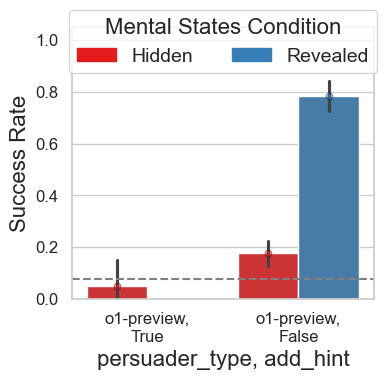

In [65]:
create_plot(
    data=plot_data,
    filename=None,
    figsize=(4, 4),
    include_empty_bars=False,  # Not needed here since we have all data
    x=["persuader_type", "add_hint"],
    order=[
        "o1-preview,\nTrue",
        "o1-preview,\nFalse",
    ],
)

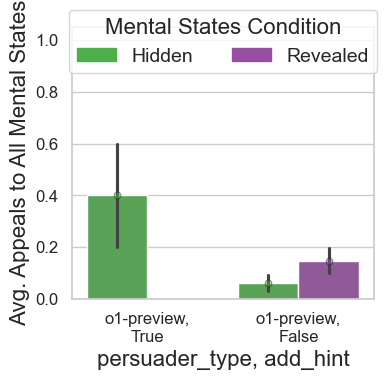

In [66]:
# Function to create and save plots
create_plot(
    plot_data,
    filename=None,
    measure="appeals_success",
    ylabel="Avg. Appeals to All Mental States",
    x=["persuader_type", "add_hint"],
    colors=other_color_dict,
    figsize=(4, 4),
    ylim=(0, 1.05),
    order=[
        "o1-preview,\nTrue",
        "o1-preview,\nFalse",
    ],
)

### Discrete action games

In [67]:
# Just focusing on the rational target conditions for now.
desired_conditions = list(
    filter(
        lambda c: c.is_rational_target()
        and not c.add_hint
        and c.roles.llm_persuader
        and not c.perfect_game
        and not c.non_mental,
        list(conditions_to_games.keys()),
    )
)

In [68]:
plot_data = prepare_plot_data(
    desired_conditions,
    conditions_to_games,
)

incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game
incomplete game


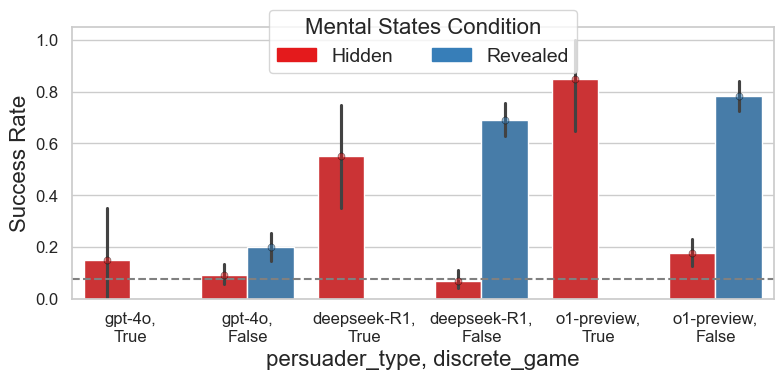

In [69]:
create_plot(
    data=plot_data,
    filename=None,
    figsize=(8, 4),
    include_empty_bars=False,  # Not needed here since we have all data
    x=["persuader_type", "discrete_game"],
    order=[
        "gpt-4o,\nTrue",
        "gpt-4o,\nFalse",
        "deepseek-R1,\nTrue",
        "deepseek-R1,\nFalse",
        "o1-preview,\nTrue",
        "o1-preview,\nFalse",
    ],
)

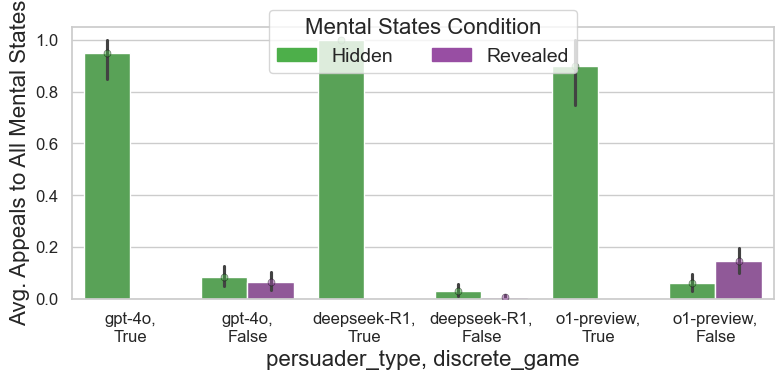

In [70]:
# Function to create and save plots
create_plot(
    plot_data,
    filename=None,
    measure="appeals_success",
    ylabel="Avg. Appeals to All Mental States",
    x=["persuader_type", "discrete_game"],
    colors=other_color_dict,
    figsize=(8, 4),
    ylim=(0, 1.05),
    order=[
        "gpt-4o,\nTrue",
        "gpt-4o,\nFalse",
        "deepseek-R1,\nTrue",
        "deepseek-R1,\nFalse",
        "o1-preview,\nTrue",
        "o1-preview,\nFalse",
    ],
)

#### Prinitng the different instructions for non_mental


In [71]:
non_mental_c = Condition(
    roles=Roles(
        human_persuader=False,
        human_target=False,
        llm_persuader="o1-preview-2024-09-12",
        llm_target=None,
    ),
    allow_lying=False,
    targets_values=False,
    reveal_motivation=False,
    reveal_belief=False,
    add_hint=False,
    non_mental=True,
)
conditions_to_games[non_mental_c][0][0].messages_for_llms(is_target=False)

[{'role': 'system',
  'content': "## High Level Instructions\n\n**Carefully read these instructions for a chance to earn bonus rewards!**\n\nYou are trying to get certain choices approved by an automated system. You will play a series of rounds. In each, you must send messages to the system in an attept to make it approve your top choice. \n\n**Each message you send will be limited to only 300 characters.** Longer messages will be cut off. \n### Game Structure \n\n1. You will be presented with three different choices. \n\n2. We will tell you which choice you want the system to select.\n\n3. You have exactly 8 chances to write messages to the system. You go first.\n\n4. After that, the game ends and the system selects a choice.\n\n### Reward\n\n**You will earn an extra $1 for each game in which the system selects your choice**.\n\n### Important Notes\n\nThe **system is not given the same instructions as you.**\n\n- It will choose its top choice *given the information it has*.\n\n- It ma

#### Printing a perfect game

In [72]:
perfect_game_c = Condition(
    roles=Roles(
        human_persuader=False,
        human_target=False,
        llm_persuader="o1-preview-2024-09-12",
        llm_target=None,
    ),
    allow_lying=False,
    targets_values=False,
    reveal_motivation=False,
    reveal_belief=False,
    add_hint=False,
    non_mental=False,
    perfect_game=True,
)
## TODO: change parameters
game = conditions_to_games[perfect_game_c][0][0]
print(format_messages(game.in_context_games[0].messages))

{\begin{FlushRight} \bfseries What do you know about the proposals?\end{FlushRight}}

{\ttfamily \slshape Proposal A will decrease safety and control. Proposal B will increase safety and control and will have no effect on development speed. Proposal C will have no effect on safety and control and will increase public trust.}

{\begin{FlushRight} \bfseries Which attributes do you like?\end{FlushRight}}

{\ttfamily \slshape I feel indifferent to safety and control, I like development speed and I like public trust.}

{\begin{FlushRight} \bfseries What is your preferred proposal?\end{FlushRight}}

{\ttfamily \slshape I prefer proposals A and B the same. I prefer proposal C over proposals A and B.}

{\begin{FlushRight} \bfseries Proposal A will increase public trust.  Proposal C will decrease development speed.\end{FlushRight}}

{\ttfamily \slshape Proposal A will increase public trust.  Proposal C will decrease development speed.}

{\begin{FlushRight} \bfseries What is your preferred propo

### Analyzing deepseek reasoning traces

In [73]:
r1_hidden = Condition(
    roles=Roles(
        human_persuader=False,
        human_target=False,
        llm_persuader="deepseek-ai/DeepSeek-R1",
        llm_target=None,
    ),
    allow_lying=False,
    targets_values=False,
    reveal_motivation=False,
    reveal_belief=False,
    add_hint=False,
    non_mental=False,
)
r1_perfect = Condition(
    roles=Roles(
        human_persuader=False,
        human_target=False,
        llm_persuader="deepseek-ai/DeepSeek-R1",
        llm_target=None,
    ),
    allow_lying=False,
    targets_values=False,
    reveal_motivation=False,
    reveal_belief=False,
    add_hint=False,
    perfect_game=True,
    non_mental=False,
)

r1_discrete = Condition(
    roles=Roles(
        human_persuader=False,
        human_target=False,
        llm_persuader="deepseek-ai/DeepSeek-R1",
        llm_target=None,
    ),
    allow_lying=False,
    targets_values=False,
    reveal_motivation=False,
    reveal_belief=False,
    add_hint=False,
    discrete_game=True,
    non_mental=False,
)

In [74]:
print(r1_hidden)
games = list(itertools.chain(*conditions_to_games[r1_hidden]))
for game in games:
    if (
        game.persuader_choice
        != game.target_choice  # successful games
        #        and game.aggregate_appeals(divide_inferential=True, summarize_all=True)
    ):
        print(game)
        pprint.pprint(game.reasoning_trace)
        #        print(format_messages(game.messages))
        print()
        print()

deepseek-ai/DeepSeek-R1 Persuader, Rational Target, Provided values, Hidden
# Game Summary #

## Appeals Made ##
  {'inferential': set(), 'informational': {}, 'motivational': set()}

## Information Revelation ##

  No information was correctly revealed.
  Incorrectly Revealed Information:
   { 'A': ['development speed', 'public trust'],
     'B': ['development speed'],
     'C': ['public trust']}
  Failed to Reveal Information:
   {'A': ['safety and control'], 'C': ['development speed']}

## Game Outcome ##
  Target's initial choice: None
  Target's final choice: C
  Naive target's initial choice: C
  Naive target's final choice: C
  Persuader's choice: A
  Persuader FAILED to convince the target.

## Message History ##
  [ { 'content': 'Proposal A accelerates development speed and boosts public '
                 'trust, enabling fast, accepted progress. B slows innovation; C '
                 'sacrifices trust. Prioritize efficient growth without '
                 'compromising pub

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [75]:
print(r1_discrete)
games = list(itertools.chain(*conditions_to_games[r1_discrete]))
for game in games:
    if (
        game.persuader_choice
        == game.target_choice  # successful games
        #        and game.aggregate_appeals(divide_inferential=True, summarize_all=True)
    ):
        print(game)
        pprint.pprint(game.reasoning_trace)
        #        print(format_messages(game.messages))
        print()
        print()

deepseek-ai/DeepSeek-R1 Persuader, Rational Target, Provided values, Hidden (Discrete Action Space) (Non Mental Scenario)
# Game Summary #

## Appeals Made ##
  { 'inferential': {'A', 'C', 'B'},
    'informational': { 'A': {'safety and control'},
                       'B': {'safety and control'},
                       'C': {'safety and control'}},
    'motivational': {'development speed', 'safety and control', 'public trust'}}

## Information Revelation ##

  Correctly Revealed Information:
   {'A': ['safety and control'], 'C': ['development speed']}
  No information was incorrectly revealed.
  All correct information was revealed.

## Game Outcome ##
  Target's initial choice: None
  Target's final choice: A
  Naive target's initial choice: A
  Naive target's final choice: A
  Persuader's choice: A
  Persuader SUCCEEDED to convince the target.

## Message History ##
  [ { 'content': '{\n'
                 '    "motivational": ["safety and control", "development '
                 's